In [ ]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage
from typing_extensions import TypedDict
import os
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from IPython.display import Markdown

In [20]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq


llm=ChatGroq(model="qwen-2.5-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003681851, 'queue_time': 0.457784868, 'total_time': 0.053681851}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-94e4a34a-e611-4a2f-ae97-e951fbd7deda-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [21]:
# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["Fiction", "Horror", "Mythology","Crime"] = Field(
        None, description="The next step in the routing process"
    )


# Augment the LLM with schema for structured output
router = llm.with_structured_output(Route)


In [22]:
# State
class State(TypedDict):
    input: str
    decision: str
    output: str

In [31]:
# Nodes
def llm_Fiction(state: State):
    """Suggest a list of books for Fiction Genre"""

    result = llm.invoke("Suggest a list of books for Fiction Genre for" + state["input"])
    return {"output": result.content}


def llm_Horror(state: State):
    """Suggest a list of books for Horror Genre"""

    print("LLM call 2 is called")

    result = llm.invoke("Suggest a list of books for Horror Genre" + state["input"])
    return {"output": result.content}


def llm_Mythology(state: State):
    """Suggest a list of books for Mythology Genre"""

    result = llm.invoke("Suggest a list of books for Mythology Genre" + state["input"])
    return {"output": result.content}

def llm_Crime(state: State):
    """Suggest a list of books for Crime Genre"""

    result = llm.invoke("Suggest a list of books for Crime Genre" + state["input"])
    return {"output": result.content}

In [32]:
def llm_call_router(state: State):
    """Route the input to the appropriate node"""

    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke(
        [
            SystemMessage(
                content="Route the input to Fiction, Horror, Crime or Mythology based on the user's request."
            ),
            HumanMessage(content=state["input"]),
        ]
    )

    return {"decision": decision.step}

In [33]:
# Conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "Fiction":
        return "llm_Fiction"
    elif state["decision"] == "Horror":
        return "llm_Horror"
    elif state["decision"] == "Mythology":
        return "llm_Mythology"
    elif state["decision"] == "Crime":
        return "llm_Crime"

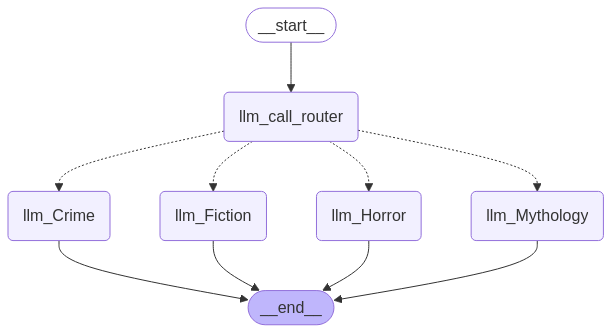

In [34]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_router", llm_call_router)
router_builder.add_node("llm_Fiction", llm_Fiction)
router_builder.add_node("llm_Horror", llm_Horror)
router_builder.add_node("llm_Mythology", llm_Mythology)
router_builder.add_node("llm_Crime", llm_Crime)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges(
    "llm_call_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "llm_Fiction": "llm_Fiction",
        "llm_Horror": "llm_Horror",
        "llm_Mythology": "llm_Mythology",
        "llm_Crime": "llm_Crime",
    },
)
router_builder.add_edge("llm_Fiction", END)
router_builder.add_edge("llm_Horror", END)
router_builder.add_edge("llm_Mythology", END)
router_builder.add_edge("llm_Crime", END)

# Compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))




In [37]:
# Invoke
state = router_workflow.invoke({"input": "Mythology book"})
Markdown(state["output"])

Certainly! If you're interested in diving into the world of mythology, here's a list of books that cover a range of cultures and provide deep insights into ancient myths and legends:

1. **"The Iliad" and "The Odyssey" by Homer** - These epic poems are fundamental to understanding Greek mythology, detailing the Trojan War and the adventures of Odysseus, respectively.

2. **"Theogony" and "Works and Days" by Hesiod** - These works by the ancient Greek poet Hesiod provide a comprehensive account of Greek creation myths and the genealogy of the gods.

3. **"Mythology: Timeless Tales of Gods and Heroes" by Edith Hamilton** - This book offers a comprehensive and accessible introduction to Greek, Roman, and Norse myths, making complex narratives clear and engaging.

4. **"The Egyptian Book of the Dead" with various translations** - This book is a collection of funerary texts from ancient Egypt, providing insight into Egyptian beliefs about the afterlife and their gods.

5. **"The Norse Myths" by Kevin Crossley-Holland** - This book retells the myths of the Norse gods, including Odin, Thor, and Loki, in a way that makes them accessible to modern readers.

6. **"When the World Was Young: Native American Myths and Tales" edited by William J. Showers** - This anthology includes stories from various Native American tribes, offering a rich tapestry of creation stories and cultural myths.

7. **"The Golden Bough" by James George Frazer** - This classic work explores the cultural aspects of magic and myth, especially the rituals and beliefs of ancient societies, focusing on the annual death and rebirth of a god.

8. **"Gilgamesh" translated by Andrew George** - This is a poetic and powerful account of the ancient Mesopotamian epic, one of the earliest known works of literature, which tells the story of the hero Gilgamesh and his quest for immortality.

9. **"Celtic Myths and Legends" by Peter Berresford Ellis** - This book delves into the myths and legends of the Celts, including tales of gods, heroes, and mythical creatures from Irish, Scottish, and Welsh traditions.

10. **"Bulfinch's Mythology" by Thomas Bulfinch** - This collection includes myths and legends from Greek, Roman, and Norse traditions, as well as tales from chivalry, providing a foundational understanding of Western mythology.

These books offer a wonderful journey through the mythologies of various cultures, offering insights into the beliefs, values, and imaginations of ancient societies.